This notebook implements the Lattice Boltzmann Method (LBM) for fluid flow passing a cylindrical obstacle.\
PS: For the best reading experience you should have the report open at the same time.

In [271]:
#!pip install cmasher -q
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm
import numpy as np 
from matplotlib.animation import *

plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.dpi"] = 150

## Initialization

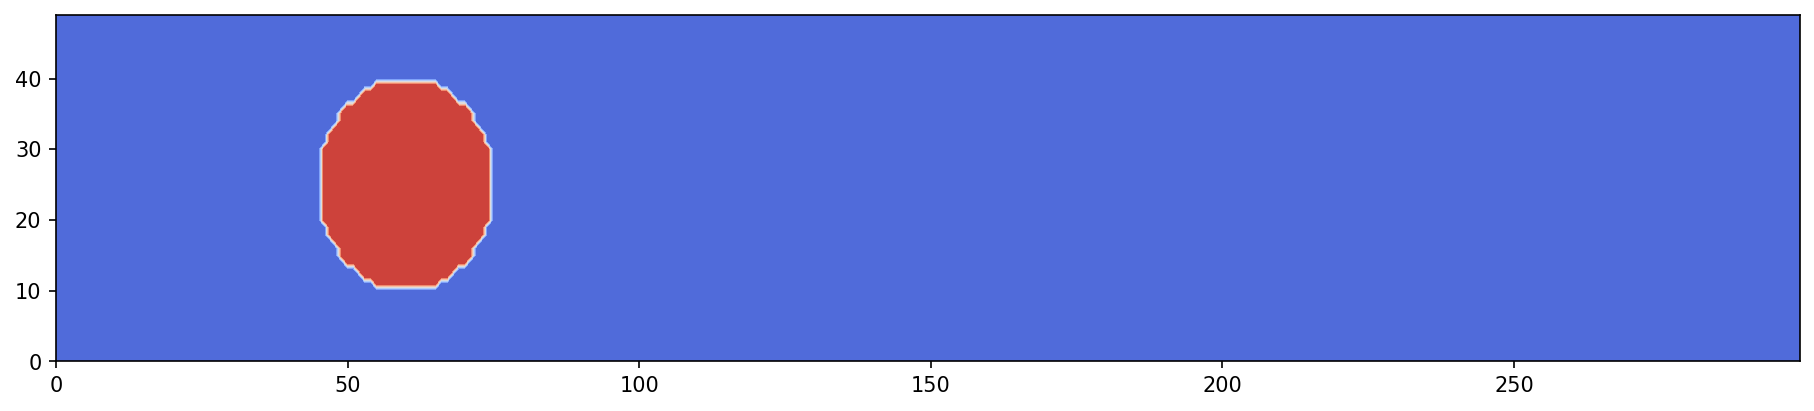

In [304]:
## Unitless physical constants
Re = 80 # Reynold's number
mass_density = 1 # Unitless mass density
inflow_speed = 0.04 # Initial horizontal inflow < 1, this is assumed to be constant throughout the simulation
dt = 1 # Change in time
record_steps = 100 # Record every 100 simulation steps 
Nx, Ny = (300, 50) # Size of the domain
R = Nx // 20 # Radius of the cylinder, this value will be used as the characteristic length
mu = mass_density * inflow_speed * R / Re # Uniteless dynamic viscousity

# Lattice configuration according to the D2Q9 scheme defined in the report
lattice_config = np.array([
    [0, 1, 0, -1, 0, 1, -1, -1, 1],
    [0, 0, 1, 0, -1, 1, 1, -1, -1],
])

lattice_indices = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
reflected_lattice_indices = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])
lattice_weights = np.array([
    4/9, # center
    1/9, 1/9, 1/9, 1/9, # sides
    1/36, 1/36, 1/36, 1/36, # diagonals
])

# These arrays will determine the flow directions
right_indices = np.array([5, 1, 8])
left_indices = np.array([7, 3, 6])
vertical_indices = np.array([0, 2, 4])

center_of_mass = (Nx//5, Ny//2)
x, y = np.arange(Nx), np.arange(Ny)
X, Y = np.meshgrid(x, y, indexing="ij")
# This is a boolean array with True when its considered to be an obstacle and False when it is fluid
cylinder = np.sqrt((X - center_of_mass[0])**2 + (Y - center_of_mass[1])**2) < R

plt.figure(figsize=[15, 3], dpi=150)
plt.contourf(X, Y, cylinder, cmap="coolwarm")
plt.show()

Computing the fluid density with equation (9) from the report.

In [305]:
def rho(lattice_matrix): # (Nx, Ny, 9) -> (Nx, Ny, 1)
    return lattice_matrix.sum(-1, keepdims=True)

Computing the equilibrium velocity density distribution using equation (11).

In [306]:
def f_eq(velocity_field, lattice_config, density_field): # (Nx, Ny, 2), (2, 9), (Nx, Ny, 1) -> (Nx, Ny, 9)
    projected_velocity_field = velocity_field @ lattice_config
    speed_field = np.linalg.norm(velocity_field, ord=2, axis=-1, keepdims=True)
    
    equilibrium_lattice_velocities = density_field * lattice_weights[None, None] * (
        1 + 3 * projected_velocity_field + 9/2 * projected_velocity_field**2 - 3/2 * speed_field**2
    ) 
    return equilibrium_lattice_velocities

Using the equilibrium lattice velocities to compute the velocity field using equation (10). This is done by projecting the lattice velocities to the x and y components using a matrix multiplication that includes the lattice configuration. Finally the 'sum' is normalized by the fluid density.

In [307]:
def get_velocity_field(equilibirum_lattice_velocities, lattice_config, density): # (Nx, Ny, 9) x (2, 9) / (Nx, Ny, 1) -> (Nx, Ny, 2)
    velocity_field = equilibirum_lattice_velocities @ lattice_config.T / density
    return velocity_field

Using the equilibrim lattice velocities to compute the outflow velocity bounary condition. The result is that the domain can be thought as being infinately extended in the x-direction since the outflow boundary does not interact with the fluid in the domain. This is done by setting the velocity in the last column to the same value as the second to last column. The 'left_indices' indicates that we are interested in the 'left' part of the lattice configuration.

In [308]:
def outflow_velocity(lattice_velocities):
    lattice_velocities[-1, :, left_indices] = lattice_velocities[-2, :, left_indices]
    return lattice_velocities # Lattice velocities but the velocity boundary condition is considered

Handing the inflow velocity boundary condition. We want to ensure that the velocity inflow (at column 0) is set to some certain value which is done here.

In [309]:
def inflow_velocity(velocity_field, initial_velocity_field): 
    # Setting the inflow velocity to the values provdided at the boundary, which is always constant 
    velocity_field[0, 1:-1] = initial_velocity_field[0, 1:-1]
    return velocity_field

Handling the boundary condition for inflow density. This is essentially an implementation of equation (16) from the report with c = 1. 
The indices are choosen in a way that it updates the horizontal component of the first column.

In [310]:
def inflow_density(equilibrium_lattice_velocities, velocity_field, density):
    vertical_density = rho(equilibrium_lattice_velocities[0, :, vertical_indices].T)
    left_density = rho(equilibrium_lattice_velocities[0, :, left_indices].T)
    density[0] = (vertical_density + 2 * left_density) / (1 - velocity_field[0, :, 0:1])
    return density

Defining the Bhatnagar-Gross-Krook collision operator (12).

In [311]:
def BGK(lattice_velocities, equilibrium_lattice_velocities):
    relaxation_time = 3 * mu + 0.5
    collided_lattice_velocities = lattice_velocities \
    - (lattice_velocities - equilibrium_lattice_velocities) / relaxation_time
    return collided_lattice_velocities

Implementing the bounce back boundary condition. This means that particle touching the obstacle will get reflected. The loop ensures that every lattice will be covered.

In [312]:
def bounce_back_boundary_condition(
    lattice_velocities, 
    collided_lattice_velocities, 
    obstacle, lattice_indices, 
    reflected_lattice_indices
):
    for i, j in zip(lattice_indices, reflected_lattice_indices):
        # Assigning the new lattice velocities that correspond to indices 'i' with 
        # the reflected lattice velocities that correspond to indices 'j'. 
        # The values are then conditioned by the obstacle (boolean) mask.
        collided_lattice_velocities[obstacle, i] = lattice_velocities[obstacle, j]
        
    return collided_lattice_velocities

We need to ensure that fluid is constantly entering the domain. This is done by updating the east indices of the lattice configuration at the first column.
No inflow at the corners as guaranteed by index slicing 1:-1.

In [313]:
def lattice_inflow_velocity(lattice_velocities, equilibrium_lattice_velocities):
    lattice_velocities[0, 1:-1, right_indices] = equilibrium_lattice_velocities[0, 1:-1, right_indices]
    return lattice_velocities

Function for updating the lattice velocities according to the streaming rule.

In [314]:
def streaming(collided_lattice_velocities, lattice_config):
    # Streamed lattice velocities is a new state of the system that is different from
    # the collided state, that is why we need to update it by successively replacing its values.
    streamed_lattice_velocities = collided_lattice_velocities
    for i, direction in enumerate(lattice_config.T):   
        horizontal_index, vertical_index = direction
        # Shifting the post collision lattice velocities in the horizontal direction (axis=0) 
        # according to the relative indices defined in the lattice_config array 
        # -1 = left, 0 = stationary, 1 = right
        horizontal_shift = np.roll(collided_lattice_velocities[..., i], horizontal_index, axis=0)

        # Simultaneously shifting in the vertical direction (axis=1).
        # Storing the result in a new lattice configuration that have been 'streamed'.
        # This is then repeated for every i:th lattice in the D2Q9 lattice configuration.
        streamed_lattice_velocities[..., i] = np.roll(horizontal_shift, vertical_index, axis=1)
        
    return streamed_lattice_velocities

## Putting everything together

In [315]:
# Function for updating the state of the system.
def update(lattice_velocities):
    # Handling the outflow boundary condition
    lattice_velocities = outflow_velocity(lattice_velocities)
    
    # Handing the inflow boundary condition, starting with the velocity
    density = rho(lattice_velocities) # Compute the density
    velocity_field = get_velocity_field(lattice_velocities, lattice_config, density)
    velocity_field = inflow_velocity(velocity_field, initial_velocity_field) 
    # Handling the density boundary condition
    density = inflow_density(lattice_velocities, velocity_field, density) 
        
    # Computing the equilibrium lattice velocities 
    equilibrium_lattice_velocities = f_eq(velocity_field, lattice_config, density) 
    
    # Making sure that fluid continously enters the domain
    lattice_velocities = lattice_inflow_velocity(lattice_velocities, equilibrium_lattice_velocities) 
    
    # Handling the collisions with BGK-collision operator
    # where the collision occurs between the particle disributions 
    collided_lattice_velocities = BGK(lattice_velocities, equilibrium_lattice_velocities) 
    
    # Collision with obstacle and top/bottom side of domain 
    collided_lattice_velocities = bounce_back_boundary_condition(
        lattice_velocities, # using the latest updated lattice velocities
        collided_lattice_velocities, # handling the collision with obstacle after collision between particles
        cylinder, # boolean mask determined by type of obstacle
        lattice_indices, # determined by the lattice configuration
        reflected_lattice_indices # determined by the lattice configuration
    )
    
    # Streaming
    updated_lattice_velocities = streaming(collided_lattice_velocities, lattice_config)
    return updated_lattice_velocities

# Initializing the velocity field such that 
# there is a constant horizontal flow form left to right 
initial_velocity_field = np.zeros([Nx, Ny, 2]) 
initial_velocity_field[..., 0] = inflow_speed

# Initializing the lattice velocities by assuming it is at equilibrium at time zero.
initial_density = np.ones([Nx, Ny, 1])
lattice_velocities = f_eq(initial_velocity_field, lattice_config, initial_density)

simulation_time_steps = 10000 # Total number of steps of the simulation
frames = simulation_time_steps // 100 
density_results = []
velocity_results = []

# Iteratively updating the lattice velocities.
for t in tqdm(range(simulation_time_steps)):
    lattice_velocities = update(lattice_velocities)

    if t % frames == 0: # Storing the results
        density  = rho(lattice_velocities)
        velocity = get_velocity_field(lattice_velocities, lattice_config, density)
        density_results.append(density), velocity_results.append(velocity)

density_results = np.array(density_results)
velocity_results = np.array(velocity_results)

density_results.shape, velocity_results.shape

100%|██████████| 10000/10000 [01:36<00:00, 104.03it/s]


((100, 300, 50, 1), (100, 300, 50, 2))

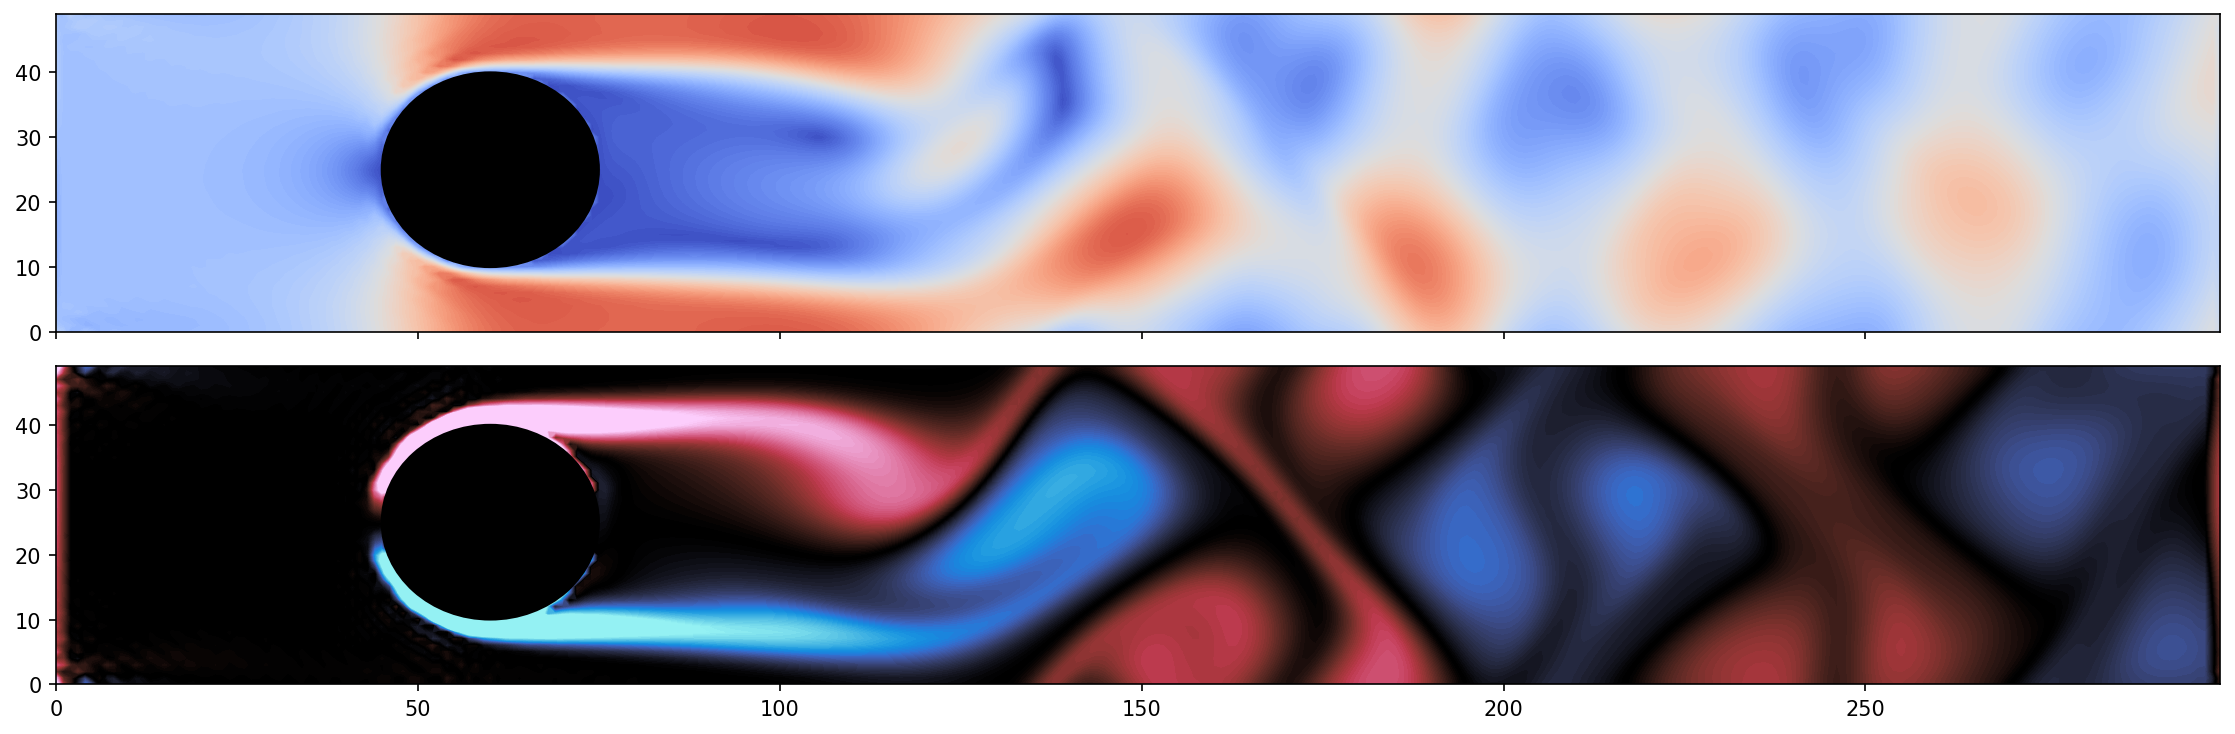

In [316]:
speed = np.linalg.norm(velocity_results, axis=-1, ord=2)

du_dx, du_dy = np.gradient(velocity_results[-1, ..., 0])
dv_dx, dv_dy = np.gradient(velocity_results[-1, ..., 1])
curl = du_dy - dv_dx

fig, ax = plt.subplots(2, 1, figsize=[15, 5], dpi=150, sharex=True, tight_layout=True)
ax[0].contourf(X, Y, speed[-1], vmin=0, vmax=0.13, levels=100, cmap="coolwarm")
ax[0].add_patch(plt.Circle(center_of_mass, R, color="black"))
ax[1].contourf(X, Y, curl, vmin=-0.015, vmax=0.015, levels=500, cmap=cmr.redshift)
ax[1].add_patch(plt.Circle(center_of_mass, R, color="black"))
plt.show()

# Animating the precomputed results

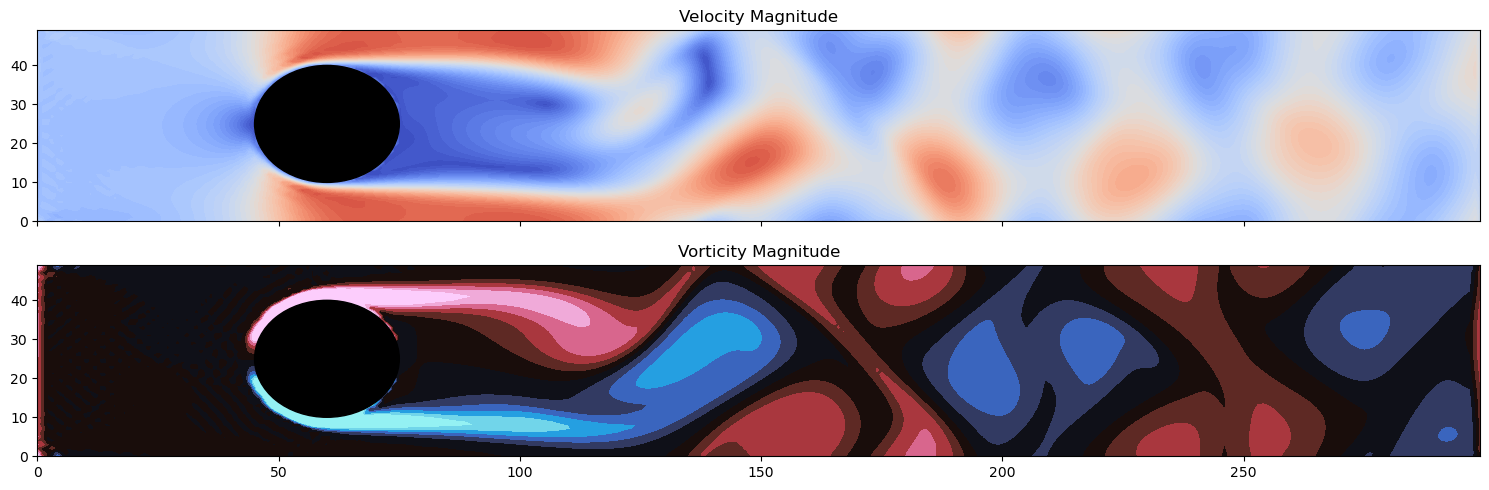

In [319]:
def plot_animation(densities, velocities):
    fig, ax = plt.subplots(2, 1, figsize=(15, 5), dpi=100, tight_layout=True, sharex=True)

    def update(frame):
        ax[0].clear()
        ax[1].clear()

        density = densities[frame]
        velocity = velocities[frame]
        
        speed = np.linalg.norm(velocity, axis=-1, ord=2)
        du_dx, du_dy = np.gradient(velocity[..., 0])
        dv_dx, dv_dy = np.gradient(velocity[..., 1])
        curl = du_dy - dv_dx

        # Velocity Magnitude Contour Plot in the top
        ax[0].contourf(X, Y, speed, levels=50, cmap="coolwarm", vmin=0, vmax=0.13)
        ax[0].set_title('Velocity Magnitude')
        ax[0].add_patch(plt.Circle(center_of_mass, R, color="black"))

        # Vorticity Magnitude Contour Plot in the bottom
        ax[1].contourf(X, Y, curl, levels=50, cmap=cmr.redshift, vmin=-0.015, vmax=0.015)
        ax[1].set_title('Vorticity Magnitude')
        ax[1].add_patch(plt.Circle(center_of_mass, R, color="black"))

    anim = FuncAnimation(fig, update, frames=len(densities), repeat=False)
    anim.save("velocity_and_vorticity.gif", writer="pillow")

plot_animation(density_results, velocity_results)